In [1]:
## Standard Statsmodels import
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.facecolor'] = 'white'
plt.style.use(['seaborn-talk'])
# pd.set_option('display.max_columns',25)

C:\Users\Joene\AppData\Local\Temp\ipykernel_428\3900563112.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-talk'])


In [2]:
## The original dataset
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTiitWN7DnJMRDcRvMKL3_xu5Y0fl2u5J2vWOrJOcOy95ZiBulg5HqMftWWeiYFYYNHMuVPDWT_vxVc/pub?output=csv")
df.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode
0,1100000,2,1.75,2050,11900,1.0,0,2050,0,1950,0,98004
1,430000,3,1.50,1690,9708,1.5,0,1690,0,1954,0,98006
2,2150000,3,2.75,3470,9610,3.0,1,3470,0,1989,2000,98034


In [4]:
#Function and Data From Previous Lesson
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    
    """
    ## Make predictions and calculate residuals
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid, line='45',fit=True,ax=axes[0]);
    
    ## Homoscedascity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()

In [5]:
import joblib
loaded_data = joblib.load("ols_results.joblib")
loaded_data.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'Outlier Scaler', 'Column Transformer', 'OLS Results'])

In [6]:
## Saving the dictionary data into separate variables
X_train_df = loaded_data['X_train']
y_train = loaded_data['y_train']
X_test_df  = loaded_data['X_test']
y_test = loaded_data['y_test']
##  Saving the model and processing tools to new vars
result = loaded_data['OLS Results']
outlier_scaler = loaded_data['Outlier Scaler']
preprocessor = loaded_data['Column Transformer']

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     187.3
Date:                Fri, 19 May 2023   Prob (F-statistic):               0.00
Time:                        09:56:32   Log-Likelihood:                -48210.
No. Observations:                3687   AIC:                         9.657e+04
Df Residuals:                    3610   BIC:                         9.705e+04
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.972e+04   2814.752     -7.007

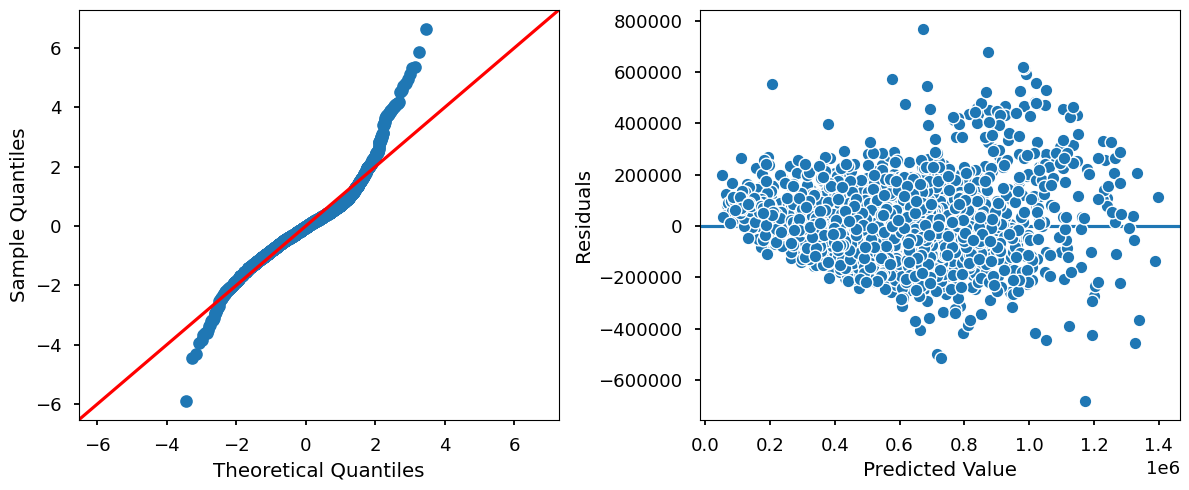

In [7]:
print(result.summary())
evaluate_ols(result,X_train_df, y_train)

In [8]:
## Getting statsmodels coefficients
coeffs = result.params
coeffs

bedrooms         -19723.359525
bathrooms         28172.329800
sqft_living         207.233425
floors           -41138.398629
waterfront       418376.338039
                     ...      
zipcode_98178   -158056.037850
zipcode_98188   -185179.202932
zipcode_98198   -190653.807548
zipcode_98199    221153.926332
const            177606.752950
Length: 78, dtype: float64

In [9]:
## Getting the True/False for which are zipcode cols
zip_cols = coeffs.index.str.contains('zipcode')

In [10]:
## slicing out the zicode coefficents to a separate series
coeffs_zips = coeffs.loc[zip_cols].copy()
coeffs_zips

zipcode_98001   -203278.840933
zipcode_98002   -204908.623666
zipcode_98003   -200571.992824
zipcode_98004    457266.881184
zipcode_98005    176257.225821
                     ...      
zipcode_98177     66476.390534
zipcode_98178   -158056.037850
zipcode_98188   -185179.202932
zipcode_98198   -190653.807548
zipcode_98199    221153.926332
Length: 70, dtype: float64

In [11]:
# slicing out the zicode coefficents to a separate series
# coeffs_main will have all coefficients EXCEPT those for zip code
coeffs_main = coeffs.loc[~zip_cols].copy()
coeffs_main

bedrooms         -19723.359525
bathrooms         28172.329800
sqft_living         207.233425
floors           -41138.398629
waterfront       418376.338039
sqft_basement       -73.783983
yr_renovated         24.836621
const            177606.752950
dtype: float64

In [12]:
## Sorting the coefficients largest to smallest
coeffs_main = coeffs_main.sort_values(ascending=False)
coeffs_main

waterfront       418376.338039
const            177606.752950
bathrooms         28172.329800
sqft_living         207.233425
yr_renovated         24.836621
sqft_basement       -73.783983
bedrooms         -19723.359525
floors           -41138.398629
dtype: float64

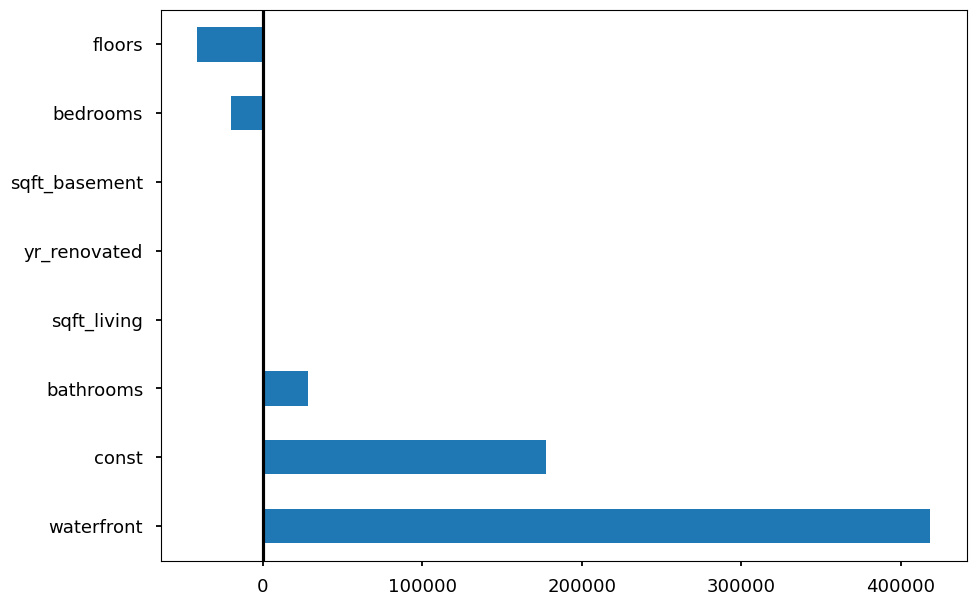

In [13]:
# We can also visualize our coeffiicents, as long as we do not include too many
coeffs_main.plot(kind='barh')
plt.axvline(0,color='k');

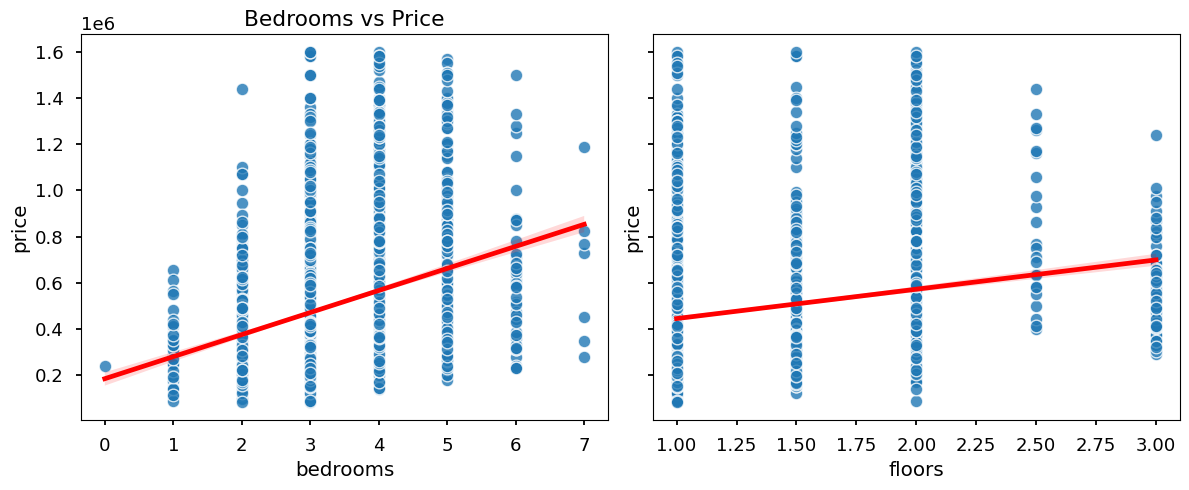

In [14]:
## visualizing variables with large negative ceoffs
fig, axes = plt.subplots(ncols=2, figsize=(12,5),
                         sharey=True)
sns.regplot(x=X_train_df['bedrooms'], y=y_train,
            scatter_kws={'ec':'white','lw':1},
            line_kws={'color':'red'}, ax=axes[0])
axes[0].set_title('Bedrooms vs Price')
sns.regplot(x=X_train_df['floors'], y=y_train,
            scatter_kws={'ec':'white','lw':1},
            line_kws={'color':'red'}, ax=axes[1])
plt.tight_layout()

In [15]:
## formatting our axis to match our dataframe floats
from matplotlib.ticker import StrMethodFormatter

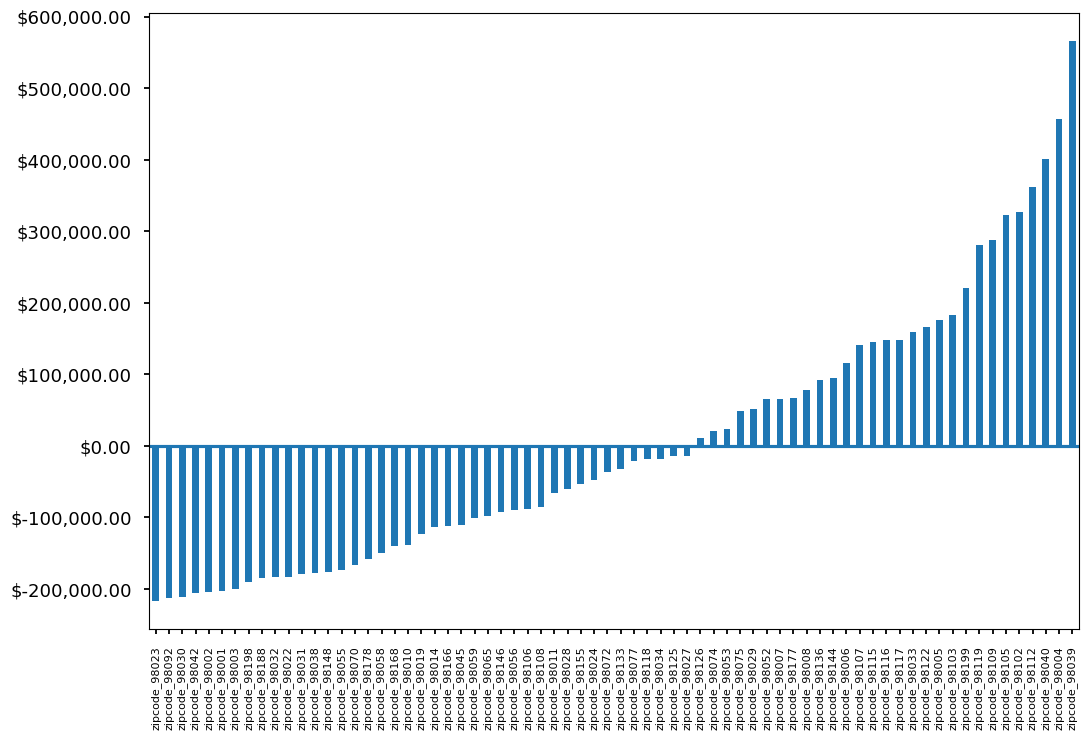

In [16]:
ax = coeffs_zips.sort_values().plot(kind='bar',figsize=(12,8))
ax.axhline()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.2f}'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=8);

In [17]:
X_train_no_zips = X_train_df.loc[:,~zip_cols]
X_test_no_zips = X_test_df.loc[:,~zip_cols]
display(X_train_no_zips.head(2),
       X_test_no_zips.head(2))

,bedrooms,bathrooms,sqft_living,floors,waterfront,sqft_basement,yr_renovated,const
1344,3.0,1.75,1850.0,1.0,0.0,0.0,0.0,1.0
1282,3.0,2.25,1870.0,1.0,0.0,430.0,0.0,1.0


,bedrooms,bathrooms,sqft_living,floors,waterfront,sqft_basement,yr_renovated,const
2041,3.0,2.50,1520.0,1.0,0.0,440.0,0.0,1.0
2607,3.0,2.25,1490.0,2.0,0.0,450.0,0.0,1.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     438.9
Date:                Fri, 19 May 2023   Prob (F-statistic):               0.00
Time:                        11:08:30   Log-Likelihood:                -50037.
No. Observations:                3687   AIC:                         1.001e+05
Df Residuals:                    3679   BIC:                         1.001e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -2.776e+04   4479.432     -6.198      0.000   -3.65e+04    -1.9e+04
bathrooms      8776.0966   7034.183      1.248      0.212   -5015.186    2.26e+04
sqft_living     200.5980      6.379     31.445      0.000     188.091     213.105
floors         2.848e+04   7908.709      3.601      0.000     1.3e+04     4.4e+04
waterfront      2.93e+05   4.49e+04      6.518      0.000    2.05e+05    3.81e+05
sqft_basement    35.0586      9.224      3.801      0.000      16.975      53.143
yr_renovated     50.1540      7.948      6.310      0.000      34.570      65.737
const          1.159e+05   1.42e+04      8.149      0.000     8.8e+04    1.44e+05
==============================================================================
Omnibus:                      606.354   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1317.222
Skew:                           0.960   Prob(JB):                    9.31e-287
Kurtosis:                       5.211   Cond. No.                     3.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

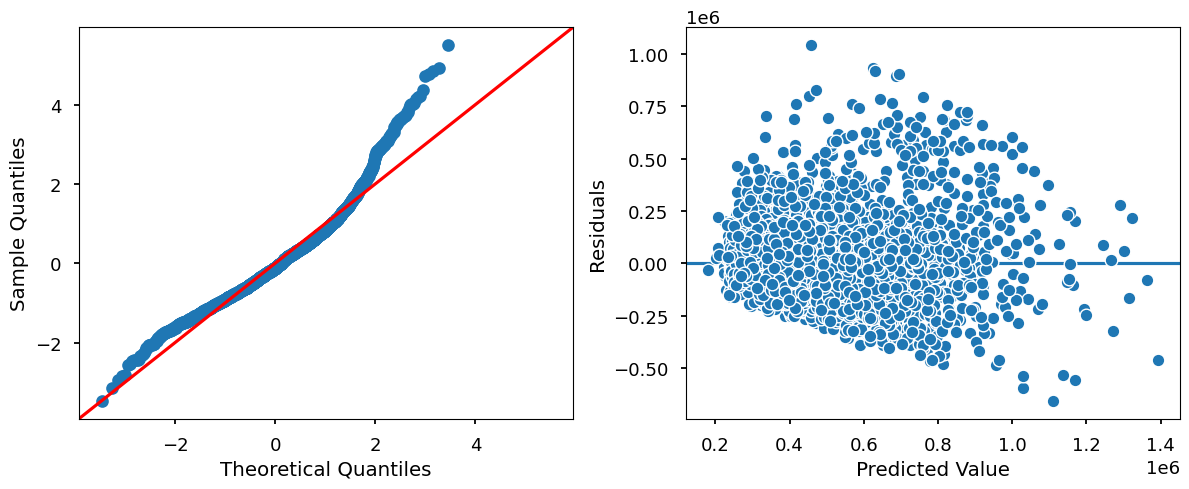

In [18]:
## Fitting a model without zipcodes 
model = sm.OLS(y_train,X_train_no_zips)
result = model.fit()
display(result.summary())
evaluate_ols(result,X_train_no_zips, y_train)